In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# name of the synthetic directory
sim_name = 'fit_to_data'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 199999
svi_id = 42 # (24,25) =  (no outer roi, outer roi)
sim_seed = -1
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
# temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
print(fit_dir)
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')


samples_dict, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

/data/edr76/gce-gp/data/synthetic_data/fit_to_data/fits/fit_7p1234567_5p23457_1p16_-1_199999_42/seed_-1_0/
/
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    ebin10_smp_svi_res_0.1_20000_mvn_8_-1_0.p
    settings_7p1234567_5p23457_1p16_-1_199999_42_-1_0.py
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_10.p
    gp2temp_allblgsebin10_svi_res_0.1_20000_mvn_8_-1_0.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_10.p
    summary.txt
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    __init__.py
    gp2temp_allblgsebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_199999_42_-1_0.cpython-311.pyc


In [5]:
# blg id and blg name
blg_id = np.arange(1,6)
blg_names = [ef.gen_blg_name_(int(blg_id[j]) - 1)[0] for j in range(len(blg_id))]

In [6]:
# load model using stored parameters

from models.poissonian_gp import EbinPoissonModel # to set GPU at the beginning
from numpyro.infer import autoguide

nfw_gamma = 1.2
ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,

        mask_roi_r_outer = 10.,
        )
# configure model, run SVI, and generate samp 
ebinmodel.Nsub = 500
ebinmodel.config_model(ebin=ebin)
ebinmodel.guide = autoguide.AutoMultivariateNormal(ebinmodel.model)
ebinmodel.init_svi(rng_key = jax.random.PRNGKey(0), optimizer = None, lr = 0.006, num_particles = 16, ebin = 10)
ebinmodel.config_temp_model(params = svi_results.params)

In [7]:
print(ebinmodel.model)
print(ebinmodel.gp_temp_list)
print(ebinmodel.blg_names)
print(len(ebinmodel.blg_temps))

<bound method EbinPoissonModel.temp_model of <models.poissonian_gp.EbinPoissonModel object at 0x7f9121f35a50>>
['blg', 'nfw']
['macias2019', 'coleman2019', 'mcdermott2022', 'mcdermott2022_bbp', 'mcdermott2022_x']
5


/data/edr76/gce-gp/nfw_priors/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-gp/nfw_priors/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


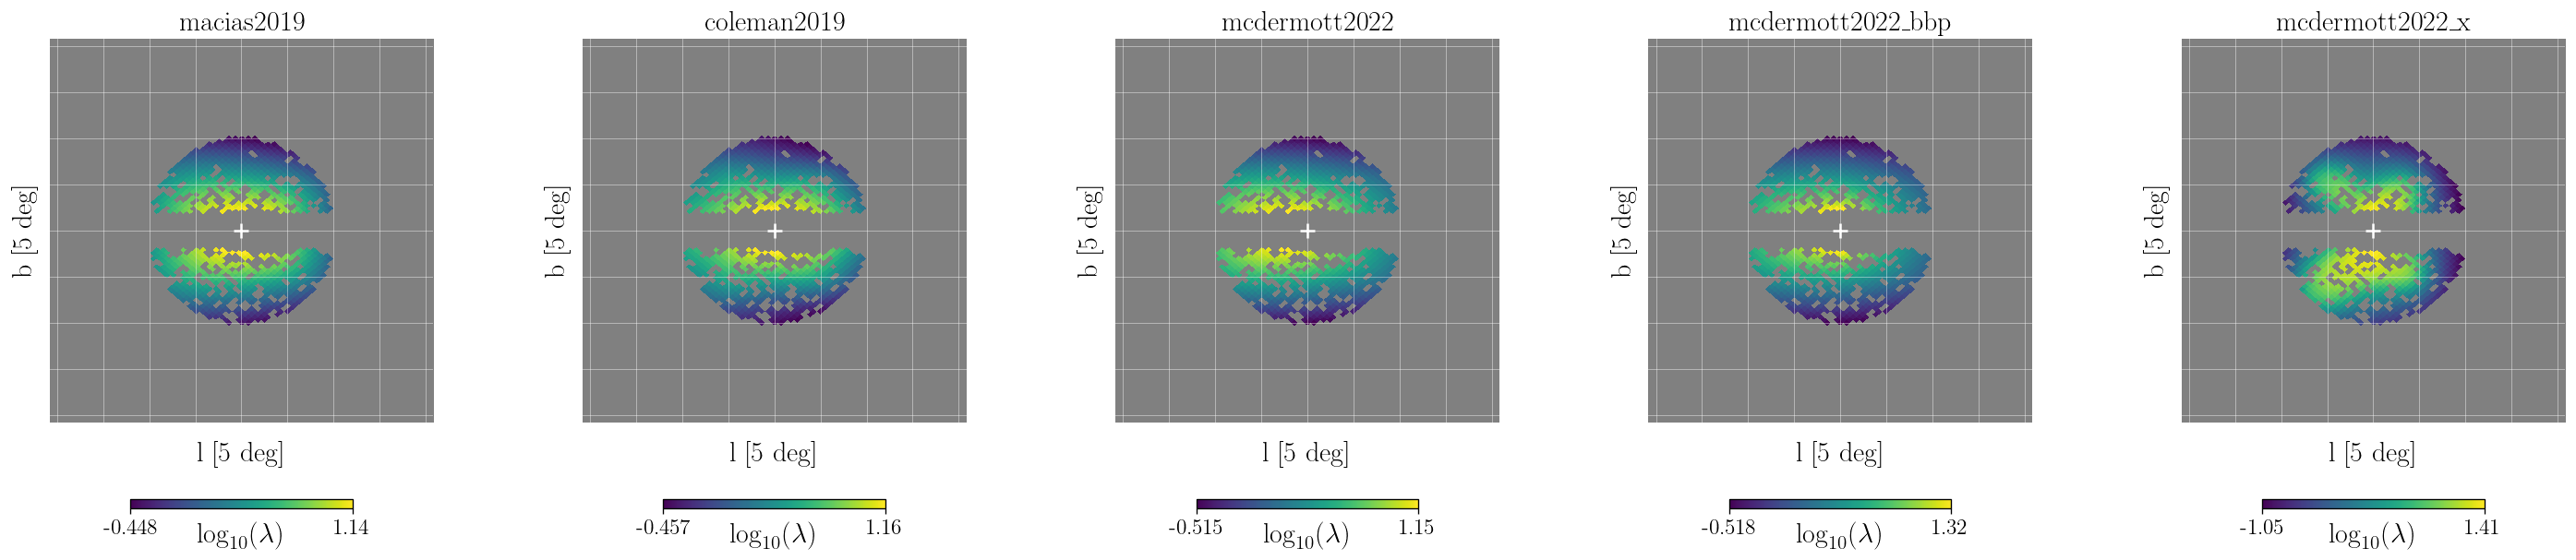

In [8]:
# load the hybrid templates 
ie = 10
nside = 128
mask_p = ebinmodel.mask_roi_arr[ie]
blg_temps_at_bin = jnp.asarray([blg_temp.at_bin(ie, mask=mask_p) for blg_temp in ebinmodel.blg_temps])

blg_temps_hp = []

fig = plt.figure(figsize=(6*5, 6), dpi= 120)
Nb = len(blg_names)
for i in range(Nb):
    ax = fig.add_subplot(1,Nb,i+1)
    plt.axes(ax)
    blg_temps_hp.append(ef.convert_masked_array_to_hp_array(blg_temps_at_bin[i], mask_p, log_option = True, nside=nside))
    ef.gnomview_plot(blg_temps_hp[i], title = blg_names[i])

In [9]:
# step 2

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 15000
str_n_steps = str(n_steps)

lr = 0.02  
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 2
str_svi_seed = str(svi_seed)

# define custom optimizer (can be None if want to use default)
import optax
import numpyro
from numpyro import optim

# custom schedule
schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.005,
    peak_value=0.02,
    warmup_steps=1000,
    transition_steps=3000,
    decay_rate=1./jnp.exp(1.),
    transition_begin=2000,
)
optimizer = optim.optax_to_numpyro(
    optax.chain(
        optax.clip(1.),
        optax.adam(learning_rate=schedule), 
    )
)

rng_key = jax.random.PRNGKey(0)
rng_key, key = jax.random.split(rng_key)
temp_svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, early_stop = np.inf, optimizer = optimizer,
)
rng_key, key = jax.random.split(rng_key) 
temp_samples = ebinmodel.cget_svi_samples(rng_key = key, num_samples=10000)

# save svi results and samples to file

file_name = ('gp2temp_allblgs' + 'ebin' + str_ebin + '_smp_svi_' + 
        str_lr + '_' + str_n_steps + '_' + 
            str_guide + '_' + str_num_particles + '_' + 
            str_sim_seed + '_' + str_svi_seed + '.p')

file_name_res = ('gp2temp_allblgs' +'ebin' + str_ebin + '_svi_res_' + 
        str_lr + '_' + str_n_steps + '_' + 
            str_guide + '_' + str_num_particles + '_' + 
            str_sim_seed + '_' + str_svi_seed + '.p')
if is_gp:
    pickle.dump(
        (temp_samples, temp_svi_results), 
        open(fit_dir + file_name, 'wb'))
else:
    pickle.dump(
        (temp_samples, temp_svi_results), 
        open(fit_dir + file_name, 'wb'))

pickle.dump(
(temp_svi_results), 
open(fit_dir + file_name_res, 'wb'))

100%|██████████| 15000/15000 [01:11<00:00, 209.06it/s, init loss: 6710.2432, min loss 1724.4756, avg loss [14926-15000]: 1968.2711]


In [10]:
keys = list(temp_samples.keys())

temp_samples_tot_list = []
for k in keys:
    if 'theta' in k:
        for i in range(len(ebinmodel.blg_names)):
            temp_samples_tot_list.append(temp_samples[k][:,i])
    else:
        temp_samples_tot_list.append(temp_samples[k])
temp_samples_tot_list = np.array(temp_samples_tot_list)

# generate samples and plot histograms of log counts
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]

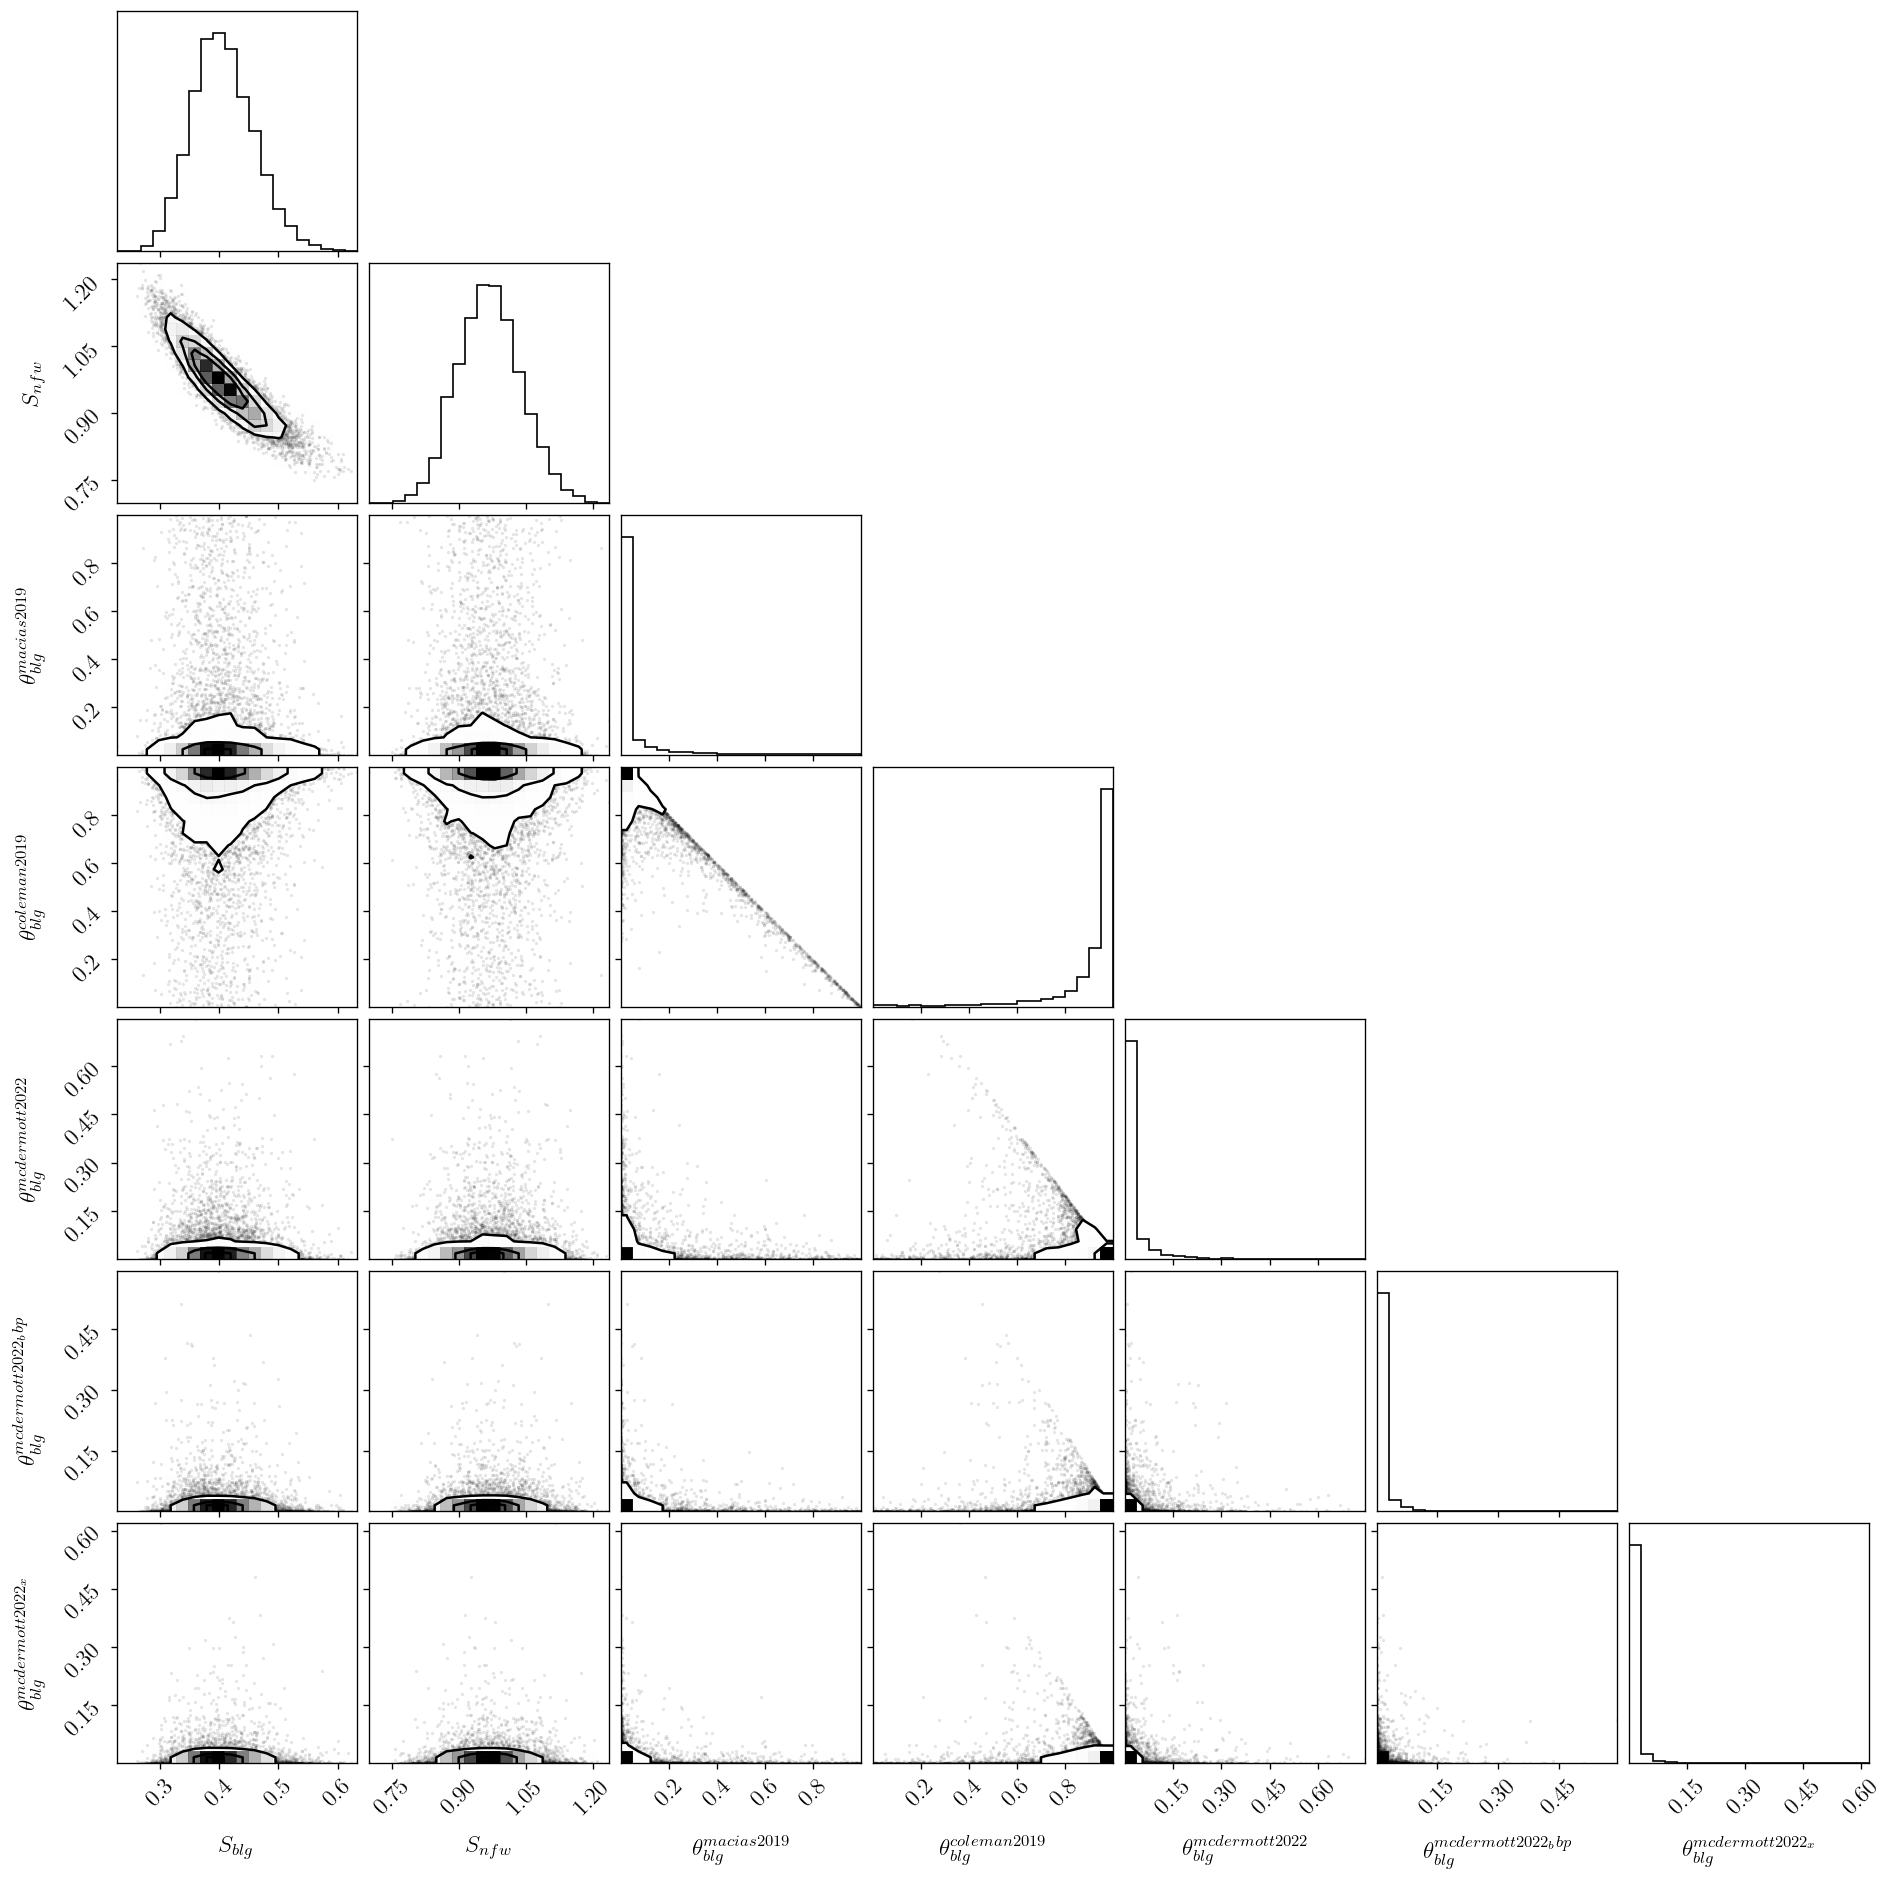

In [11]:
import corner

Np = temp_samples_tot_list.shape[0]
Ntot = temp_samples_tot_list.T.shape[1]

def gen_labels(keys):
    def format_S(k):
        if 'S' in k:
            return '$S_{'+k.split('_')[1]+'}$'
        return '$'+k+'$'
    def format_theta(k, subscript):
        return '$\\theta_{'+k.split('_')[1]+'}'+'^{'+subscript+'}$'
    
    labels = []
    for k in keys:
        if 'theta' in k:
            for i in range(len(ebinmodel.blg_names)):
                labels.append(format_theta(k, ebinmodel.blg_names[i]))
        else:
            labels.append(format_S(k))
    return labels
labels = gen_labels(keys)
# labels =['$S_{blg}$', '$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{nfw}$', '$S_{pib}$', '$S_{psc}$', 
#          '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$','$\\theta_{pib}^{a}$']
# labels = ['$S_{bub}$', '$S_{ics}$', '$S_{pib}$', '$S_{psc}$', '$S_{blg}$', '$S_{iso}$', '$S_{nfw}$','$\\gamma$']

fig = corner.corner(temp_samples_tot_list.T, labels = labels, )
axes = np.array(fig.axes).reshape((Ntot, Ntot))
# for i in range(Np):
#     ax = axes[i,i]
#     ax.axvline(p_tr[i], color='red', linestyle='--')

In [12]:
from utils import create_mask as cm
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
# augment samples_dict to include entire maps of samples
temp_sample_dict_cmask = ef.generate_temp_sample_maps_theta(temp_samples, ebinmodel, gp_samples = None, custom_num = 1000, custom_mask = mask, nfw_gamma = ebinmodel.nfw_gamma) # template over custom mask

names = list(temp_sample_dict_cmask.keys())
for name in names:
    temp_samples[name + '_cmask'] = temp_sample_dict_cmask[name]

blg


100%|██████████| 1000/1000 [00:00<00:00, 1294.57it/s]


nfw


100%|██████████| 1000/1000 [00:02<00:00, 410.45it/s]


In [13]:
# consistency check
num_samples = 1000
name = 'blg'
S_blg = temp_samples['S_' + name][:num_samples]
blg_temps_at_bin = jnp.asarray([blg_temp.at_bin(ie, mask=mask) for blg_temp in ebinmodel.blg_temps])
theta = temp_samples['theta_' + name][:num_samples]
blg_temp = np.dot(theta, blg_temps_at_bin)
og_blg_temp = np.array([S_blg[i] * blg_temp[i,:] for i in tqdm(range(num_samples))])

100%|██████████| 1000/1000 [00:00<00:00, 1461.57it/s]


In [14]:
theta.shape

(1000, 5)

In [15]:
blg_list = []
for i in range(theta.shape[-1]):
    theta[:,i][:,None] * blg_temps_at_bin[i,:][None,:]
    blg_list.append(S_blg[:,None] * (theta[:,i][:,None] * blg_temps_at_bin[i,:][None,:]))
blg_list = np.array(blg_list)

In [16]:
theta.mean(axis = 0)

Array([0.06732473, 0.8887271 , 0.02563278, 0.01032512, 0.00799027],      dtype=float32)

In [17]:
blg_list.shape

(5, 1000, 5938)

In [18]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '1'

# name of the synthetic directory
sim_name = 'fit_to_data'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 199999
svi_id = 42 # (24,25) =  (no outer roi, outer roi)
sim_seed = -1
svi_seed = 0

In [19]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
print(fit_dir)
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')


samples_dict, _ = pickle.load(open(fit_dir + fit_file_name, 'rb'))

/data/edr76/gce-gp/data/synthetic_data/fit_to_data/fits/fit_7p1234567_5p23457_1p16_-1_199999_42/seed_-1_0/
/
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_12.p
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
    ebin10_smp_svi_res_0.1_20000_mvn_8_-1_0.p
    settings_7p1234567_5p23457_1p16_-1_199999_42_-1_0.py
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_2.p
    gp2temp_allblgsebin10_svi_res_0.02_15000_mvn_8_-1_10.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_2.p
    gp2temp_allblgsebin10_svi_res_0.1_20000_mvn_8_-1_0.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_10.p
    summary.txt
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_12.p
    gp2temp_allblgsebin10_smp_svi_0.02_15000_mvn_8_-1_0.p
    __init__.py
    gp2temp_allblgsebin10_smp_svi_0.1_20000_mvn_8_-1_0.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_199999_42_-1_0.cpython-311.pyc


In [21]:
# # 1d slices
# # load cartesian grid
# n_pixels = 40 # set to 40 if too slow
# Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = n_pixels)

n_pixels = 160

# cartesian map of masks to keep track of masking for plots
mask_map = np.zeros((~mask_p).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, mask_p, n_pixels = n_pixels, nside = 128, nan_fill = True) # doesn't matter what mask used

# cartesian gp samples
exp_gp_samples = samples_dict['gp_cmask']
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels = n_pixels, nside = 128)

# cartesian nfw map and blg maps
nfw_cart = ef.multi_healpix_to_cart(temp_sample_dict_cmask['nfw'], mask, n_pixels = n_pixels, nside = 128)
blg_cart = ef.multi_healpix_to_cart(temp_sample_dict_cmask['blg'], mask, n_pixels = n_pixels, nside = 128)

# pieces of blg cartesian
blg_pieces_cart = np.array([ef.multi_healpix_to_cart(blg_list[i], mask, n_pixels = n_pixels, nside = 128) for i in range(len(blg_list))])

100%|██████████| 1000/1000 [00:24<00:00, 40.43it/s]


In [22]:
pickle.dump(
    (temp_samples, temp_sample_dict_cmask, blg_list),
    open('../figures/data/figdata_12.p', 'wb')
)

pickle.dump(
    (mask_map_cart, exp_gp_samples_cart, nfw_cart, blg_cart, blg_pieces_cart), 
    open('../figures/data/figdata_12_cart.p', 'wb'))

In [23]:
temp_samples.keys()

dict_keys(['S_blg', 'S_nfw', 'theta_blg', 'blg_cmask', 'nfw_cmask'])

Slice at y = 3.37500 deg


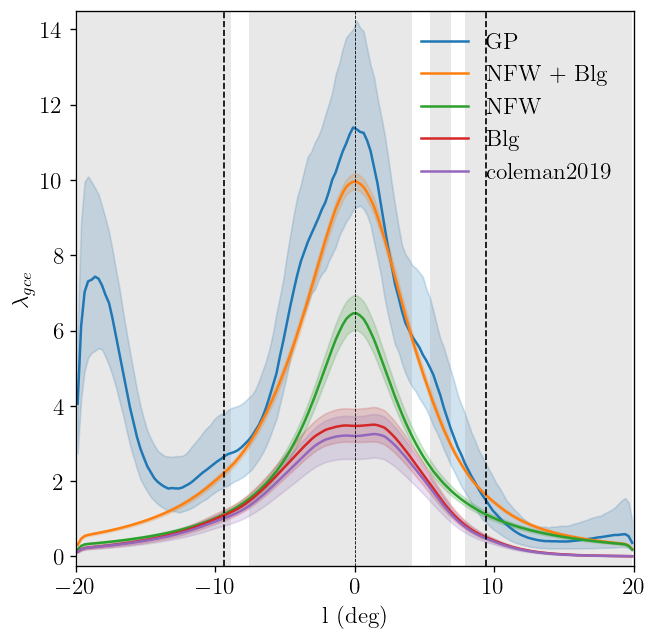

In [24]:
from utils import ed_plotting as eplt

fig, axes = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
slice_val = 3.2
# 1d slice of GCE

q_list = []
q_list.append(np.percentile(exp_gp_samples_cart, [16,50,84], axis = 0)) # cartesian sample map quantiles
q_list.append(np.percentile(blg_cart + nfw_cart, [16,50,84], axis = 0)) # cartesian sample map quantiles
q_list.append(np.percentile(nfw_cart, [16,50,84], axis = 0)) # cartesian sample map quantiles
q_list.append(np.percentile(blg_cart, [16,50,84], axis = 0)) # cartesian sample map quantiles
idx = np.argmax(theta.mean(axis = 0))
q_list.append(np.percentile(blg_pieces_cart[idx], [16,50,84], axis = 0)) # cartesian sample map quantiles
# [q_list.append(np.percentile(blg_pieces_cart[i], [16,50,84], axis = 0)) for i in range(len(blg_pieces_cart))] # cartesian sample map quantiles

q_labels = ['GP', 'NFW + Blg', 'NFW', 'Blg', ef.gen_blg_name_(idx)[0]]
q_colors = ['C' + str(i) for i in range(len(q_list))]

plt.axes(axes)
eplt.cart_plot_1d_multi(q_list, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_colors = q_colors, line_color = 'green', q_labels = q_labels,
    )
plt.axvline(np.sqrt(10.**2. - 3.375**2.), c = 'k', ls = '--', lw = 1)
plt.axvline(-np.sqrt(10.**2. - 3.375**2.), c = 'k', ls = '--', lw = 1)

Slice at x = 3.37500 deg


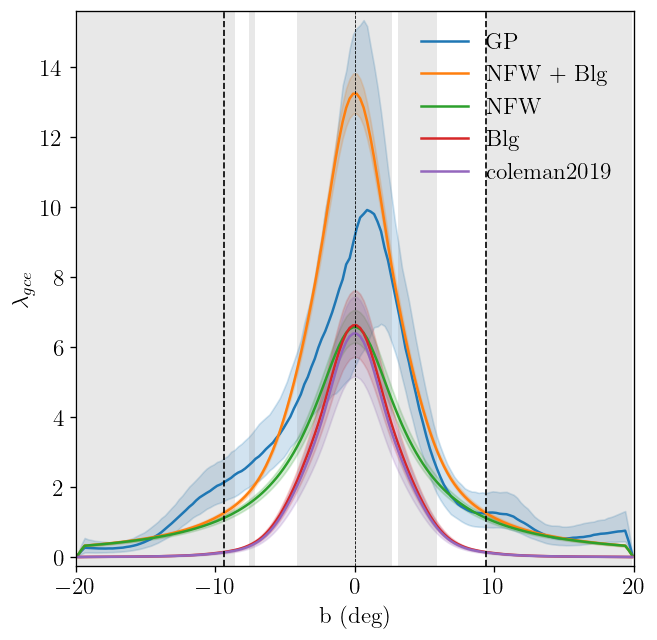

In [25]:
from utils import ed_plotting as eplt

fig, axes = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
slice_val = 3.2
# 1d slice of GCE

plt.axes(axes)
eplt.cart_plot_1d_multi(q_list, 
    slice_dir = 'vertical', slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = '$\lambda_{gce}$', q_colors = q_colors, line_color = 'green', q_labels = q_labels,
    )
plt.axvline(np.sqrt(10.**2. - 3.375**2.), c = 'k', ls = '--', lw = 1)
plt.axvline(-np.sqrt(10.**2. - 3.375**2.), c = 'k', ls = '--', lw = 1)

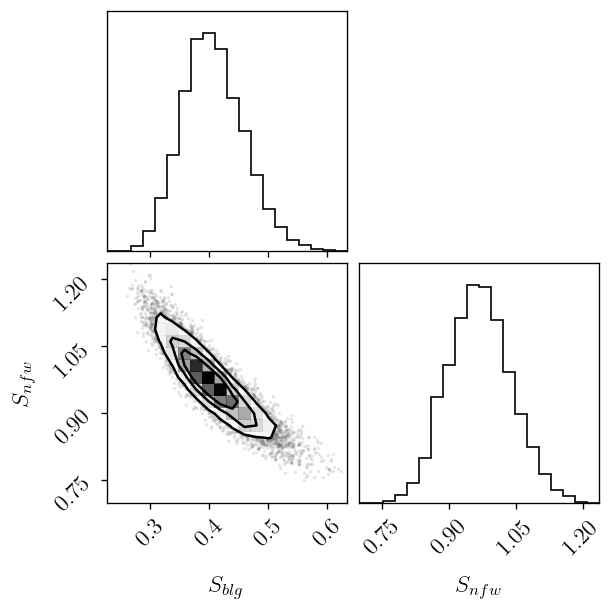

In [26]:
keys = list(temp_samples.keys())

temp_samples_tot_list = []
for k in keys:
    if k not in ['S_nfw', 'S_blg', 'gamma']:
        continue
    else:
        temp_samples_tot_list.append(temp_samples[k])
temp_samples_tot_list = np.array(temp_samples_tot_list)

# generate samples and plot histograms of log counts
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]
import corner

Np = temp_samples_tot_list.shape[0]
Ntot = temp_samples_tot_list.T.shape[1]

def gen_labels(keys):
    def format_S(k):
        if 'S' in k:
            return '$S_{'+k.split('_')[1]+'}$'
        elif 'gamma' in k:
            return '$\\gamma$'
        return '$'+k+'$'
    def format_theta(k, subscript):
        return '$\\theta_{'+k.split('_')[1]+'}'+'^{'+subscript+'}$'
    
    labels = []
    for k in keys:
        if 'theta' in k:
            for i in range(len(ebinmodel.blg_names)):
                labels.append(format_theta(k, ebinmodel.blg_names[i]))
        else:
            labels.append(format_S(k))
    return labels
labels = gen_labels(keys)
# labels =['$S_{blg}$', '$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{nfw}$', '$S_{pib}$', '$S_{psc}$', 
#          '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$','$\\theta_{pib}^{a}$']
# labels = ['$S_{bub}$', '$S_{ics}$', '$S_{pib}$', '$S_{psc}$', '$S_{blg}$', '$S_{iso}$', '$S_{nfw}$','$\\gamma$']

fig = corner.corner(temp_samples_tot_list.T, labels = labels, )
axes = np.array(fig.axes).reshape((Ntot, Ntot))
# for i in range(Np):
#     ax = axes[i,i]
#     ax.axvline(p_tr[i], color='red', linestyle='--')

(0.0, 20.0)

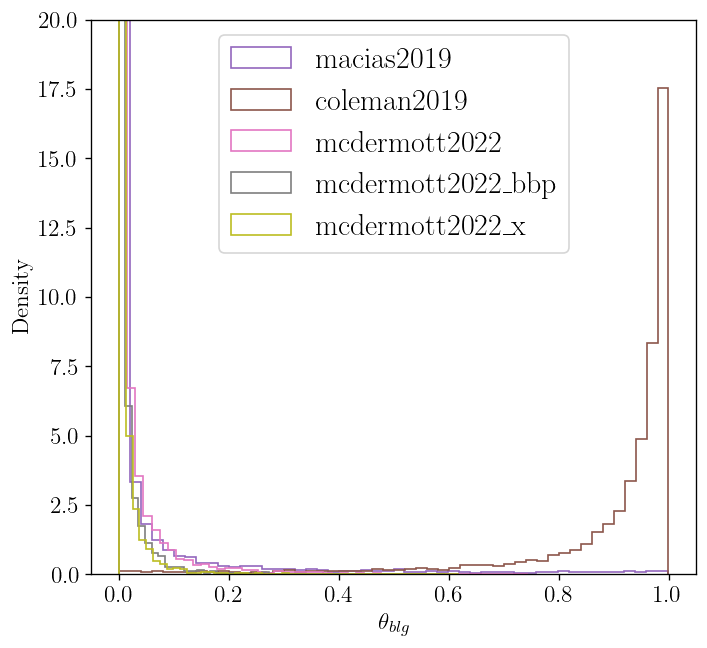

In [27]:
fig = plt.figure(figsize=(6.5, 6), dpi= 120)
for n in range(temp_samples['theta_blg'].shape[1]):
    plt.hist(temp_samples['theta_blg'][:,n], bins = 50, histtype = 'step', color = 'C' + str(n + 4), density = True, label = ebinmodel.blg_names[n])
plt.xlabel('$\\theta_{blg}$')
plt.ylabel('Density')
plt.legend()
plt.ylim(0, 20)